testing keras custom layer stuff

In [10]:
# import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import tensorflow as tf
from tensorflow.keras import Input, Model, constraints
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import time

define classes:

In [11]:
# randomizer seed:
np.random.seed(0)

# need to define a constraint for training the parameters:
class OrderedConstraint(constraints.Constraint):
    # constructor:
    def __init__(self):
        pass

    # call function for constraint:
    def __call__(self, W):
        return tf.sort(W, axis = 2)

# first layer -> membership layer:
class MF_Layer(Layer): 
    # constructor:
    def __init__(self, num_inputs, num_mfs, mf_type, **kwargs):
        super(MF_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs

        # check if string passed:
        if not type(mf_type) is str:
            raise TypeError('Only strings are permitted to be passed')
        
        # check if a recognized membership function was passed:
        if any(mf in mf_type for mf in ['Smoothed Triangular', 'Gaussian', 'Generalized Bell']):
            print('Accepted Membership Function passed')
        else:
            raise ValueError('Unrecognized MF passed to function')
        
        # assign mf type to object, which will determine the number of parameters generated:
        if mf_type == 'Gaussian':
            self.mf_type = 'Gaussian'
            self.num_antecedents = 2
            self.constraints = None
            self.init_max = 50.0
            self.init_min = 0.0
        elif mf_type == 'Smoothed Triangular':
            self.mf_type = 'Smoothed Triangular'
            self.num_antecedents = 3
            self.constraints = OrderedConstraint()
            self.init_max = 50.0
            self.init_min = 0.0
        elif mf_type == 'Generalized Bell':
            self.mf_type = 'Generalized Bell'

            self.num_antecedents = 3
            self.constraints = None
            self.init_max = 50.0
            self.init_min = 1.0

        # need to initialize antecedent parameters
        self.mf_params = self.add_weight(
            shape = (self.num_inputs, self.num_mfs, self.num_antecedents),             
            initializer= tf.keras.initializers.RandomUniform(self.init_min, self.init_max),
            trainable = True,
            name = 'Antecedent_Params',
            constraint = self.constraints
        )

    # custom setting of weights:
    def set_weights(self, params):
        # this function is used to set weights based on what a user provides
        # user must provide weights in the form of a np.array of shape (num_mfs, num_params)

        if params.shape != (self.num_inputs, self.num_mfs, self.num_antecedents):
            raise ValueError(f'Parameters provided are not of correct shape, expected ({self.num_inputs}, {self.num_mfs}, {self.num_antecedents})')

        self.mf_params = params

    # function call:
    def call(self, inputs):
        # need to initialize the membership values:
        membership_values = []

        # for every input:
        for i in range(self.num_inputs):
            # get the memberships for that input:
            input_mf_params = self.mf_params[i]

            # need to now compute the fuzzified value for each membership function:
            fuzzified_values = []

            # for every membership function:
            for j in range(self.num_mfs):

                # if gaussian:
                if self.mf_type == 'Gaussian':
                    # define parameters:
                    mean = input_mf_params[j, 0]  # mean of the gaussian
                    std = input_mf_params[j, 1]   # standard deviation of the gaussian

                    # compute output:
                    output = tf.exp(-0.5 * tf.square((inputs[:, i] - mean) / (std + 1e-6)))
                    fuzzified_values.append(output)

                # if smoothed triangular:
                if self.mf_type == 'Smoothed Triangular':
                    # define parameters
                    a = input_mf_params[j, 0]   # a parameter
                    b = input_mf_params[j, 1]   # b parameter
                    c = input_mf_params[j, 2]   # c parameter

                    # smoothing factor beta:
                    beta = 100.0

                    # check if we are on the edges:
                    is_left_edge = tf.equal(a, b)
                    is_right_edge = tf.equal(b, c)

                    # compute softplus-based smoothed triangular membership function:
                    left = tf.nn.softplus(beta * (inputs[:, i] - a)) / (tf.nn.softplus(beta * (b - a)) + 1e-6)
                    right = tf.nn.softplus(beta * (c - inputs[:, i])) / (tf.nn.softplus(beta * (c - b)) + 1e-6)

                    # deal with edge case:
                    left = tf.where((inputs[:, i] == a) & is_left_edge, 1.0, left)
                    right = tf.where((inputs[:, i] == c) & is_right_edge, 1.0, right)

                    # compute output:
                    output = tf.maximum(0.0, tf.minimum(left, right))
                    fuzzified_values.append(output)

                # if generalized bell:
                if self.mf_type == 'Generalized Bell':
                    # define parameters
                    a = input_mf_params[j, 0]
                    b = input_mf_params[j, 1]
                    c = input_mf_params[j, 2]

                    # clamp b:
                    b = tf.clip_by_value(b, 1e-6, 5.0)

                    # compute output:
                    output = 1 / (1 + tf.abs((inputs[:, i] - c) / (a + 1e-6)) ** (2 * b))
                    fuzzified_values.append(output)
            
            # need to now stack the mf values for that given input:
            membership_values.append(tf.stack(fuzzified_values, axis = -1))

        # stack everything and return:
        return tf.stack(membership_values, axis = 1)
    
# second layer -> firing strength layer:
class FS_Layer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(FS_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

    # call function:
    def call(self, membership_values):
        # this layer accepts the membership values, which have shape (batch_size, num_inputs, num_mfs):
        batch_size = tf.shape(membership_values)[0]

        # initialize the firing strengths:
        firing_strengths = tf.ones((batch_size, self.num_rules), dtype = tf.float32)

        # generate all the rule combinations:
        rules = list(product(range(self.num_mfs), repeat = self.num_inputs))    # example [(0, 0, 0), (0, 0, 1), ...]

        # need to check each input, each mf combination, and multiply their values together:
        for rule_index, combination in enumerate(rules):
            # print(f'combination: {combination}')
            rule_strength = tf.ones((batch_size, ), dtype = tf.float32)

            # for every input and membership function:
            for input_index, mf_index in enumerate(combination):
                # print(f'input: {input_index + 1} | mf: {mf_index + 1}')

                # correctly extract the fuzzified values based on the combination index:
                rule_strength *= membership_values[:, input_index, mf_index] + 1e-6
            
            # update the firing strengths:
            rule_strength = tf.expand_dims(rule_strength, axis = -1)  # shape: (batch_size, 1)
            firing_strengths = tf.concat(
                [firing_strengths[:, :rule_index], rule_strength, firing_strengths[:, rule_index + 1:]],
                axis = 1,
            )
            # print(f'firing strength: {firing_strengths}')

        return firing_strengths
    
# third layer -> normalization layer:
class NM_Layer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(NM_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs

    # call function:
    def call(self, firing_strengths):
        # this function accepts inputs of size (batch_size, num_rules).
        # need to first get the total firing strength:
        total_firing_strength = tf.reduce_sum(firing_strengths, axis = 1, keepdims = True)
        
        # can now normalize the firing strengths:
        normalized_strengths = firing_strengths / (total_firing_strength + 1e-10)   # add a buffer in case the total firing strength is zero

        return normalized_strengths
    
# fourth layer -> consequent layer:
class CN_Layer(Layer):
    # constructor: 
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(CN_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

        # need to initialize the consequent parameters:
        self.consequent_params = self.add_weight(
            shape = (self.num_rules, self.num_inputs + 1),
            initializer = tf.keras.initializers.RandomUniform(-1.0, 1.0, seed = 1234),
            trainable = True,
            name = 'Consequent_Params'
        )

    # this function is used for manually setting the consequent parameters:
    def set_cons(self, params):
        # this function accepts parameters as an array of size (num_rules, num_inputs + 1):
        if params.shape != (self.num_rules, self.num_inputs + 1):
            raise ValueError(f'Parameters provided are not of correct shape, expected ({self.num_rules}, {self.num_inputs + 1})')
        
        # assign parameters:
        self.consequent_params = params

    # call function:
    def call(self, input_list):
        # unpack inputs from list:
        normalized_strengths, inputs = input_list

        # get the batch size:
        batch_size = tf.shape(normalized_strengths)[0]

        # the output is given by the multiplication of the inputs with the consequent weights,
        # such as: o_k = w_bar_k * (x_1 * p_k + x_2 * q_k + x_3 * r_k + ... + s_k)
        # can therefore extend the inputs to be (batch_size, num_inputs + bias) for ease of multiplication:
        inputs_with_bias = tf.concat([inputs, tf.ones((batch_size, 1), dtype = tf.float32)], axis = -1)

        # need to now reshape the normalized strengths to be of size (batch_size, num_rules, 1)
        # this effectively flips it into a 'column vector' of sorts, where each individual value is now vertically aligned
        normalized_strengths = tf.reshape(normalized_strengths, (batch_size, self.num_rules, 1))

        # get the consequent parameters, which have shape (num_rules, num_inputs + 1):
        consequent_params = self.consequent_params

        # expand inputs with bias to match the rule axis: (batch_size, num_rules, num_inputs + 1)
        inputs_with_bias_expanded = tf.expand_dims(inputs_with_bias, axis = 1)

        # calculate the consequent for each rule
        consequents = tf.reduce_sum(normalized_strengths * inputs_with_bias_expanded * consequent_params, axis = 2)

        return consequents

# fifth layer -> output layer:
class O_Layer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(O_Layer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_output = num_mfs

    # call function:
    def call(self, consequents):
        output = tf.reduce_sum(consequents, axis = 1, keepdims = True)
        return output
    
# define a custom function for building models:
def BuildAnfis(input_shape, num_inputs, num_mfs, mf_type, rate):
    # define the inputs:
    inputs = Input(shape = input_shape)

    # add the custom layers:
    membership_layer = MF_Layer(num_inputs = num_inputs, num_mfs = num_mfs, mf_type = mf_type)(inputs)
    firing_layer = FS_Layer(num_inputs = num_inputs, num_mfs = num_mfs)(membership_layer)
    normalization_layer = NM_Layer(num_inputs = num_inputs, num_mfs = num_mfs)(firing_layer)
    consequent_layer = CN_Layer(num_inputs = num_inputs, num_mfs = num_mfs)([normalization_layer, inputs])
    output_layer = O_Layer(num_inputs = num_inputs, num_mfs = num_mfs)(consequent_layer)

    # create and compile the model:
    model = Model(inputs = inputs, outputs = output_layer)
    model.compile(optimizer = Adam(learning_rate = rate), 
                  loss = 'mse', 
                  metrics = ['mae', tf.keras.metrics.RootMeanSquaredError()])

    return model

values for debugging the model:


In [12]:
# these are the testing parameters that I am using for the membership functions:
params = tf.constant(np.array([
    [  # Parameters for input 1
        [0.0, 0.0, 6.0],
        [5/6, 5.0, 55/6],
        [4.0, 10.0, 10.0]
    ],
    [  # Parameters for input 2
        [0.0, 0.0 , 15.0],
        [25/12, 12.5, 275/12],
        [10.0, 25.0, 25.0]
    ],
    [  # Parameters for input 3
        [0.0, 0.0, 30.0],
        [25/6, 25.0, 275/6],
        [15.0, 50.0, 50.0]
    ]
]), dtype = tf.float32)

# these are testing parameters used for debugging:
cons_params = tf.ones(shape = (27, 4), dtype = tf.float32)

# these are testing inputs used for debugging:
input = tf.constant([[8, 5, 32]], dtype = tf.float32)
# input = tf.constant([[8, 5, 32], [2, 17, 22]], dtype = tf.float32)

need to now import the data:

In [13]:
# import data from csv as pandas dataframe:
data = pd.read_csv('V3_Data.csv')
print('data loaded successfully')

data loaded successfully


split into x and y:

In [14]:
# perform split:
x_data = data.drop(columns = 'Suitability').astype('float32').values
y_data = data['Suitability'].astype('float32').values

need to now split into training, validation, and testing sets:

In [15]:
# split the data using train_test_split:
x_train, x_filler, y_train, y_filler = train_test_split(x_data, y_data, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_filler, y_filler, test_size = 0.5)

# get the split results:
print(f'training examples have shape: {x_train.shape}')
print(f'validation examples have shape: {x_val.shape}')
print(f'testing examples have shape:{x_test.shape}\n')

training examples have shape: (8000, 3)
validation examples have shape: (1000, 3)
testing examples have shape:(1000, 3)



scale data:

In [16]:
# define a scaler:
scaler = StandardScaler()

# scale each set:
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# save the scaler:
# dump(scaler, open('scaler.pkl', 'wb'))

make model:

In [17]:
# make model:
tf.keras.backend.clear_session()
model = BuildAnfis((3,), 3, 3, mf_type = 'Gaussian', rate = 0.001)
model.layers[1].mf_params.numpy()

Accepted Membership Function passed


array([[[24.208355  , 31.69973   ],
        [35.635834  , 45.851334  ],
        [24.816496  , 19.698036  ]],

       [[ 0.42693615, 12.4834    ],
        [21.731865  , 38.35317   ],
        [30.412657  , 15.503777  ]],

       [[18.839067  ,  4.4355154 ],
        [19.670946  , 21.14445   ],
        [27.53619   , 28.41637   ]]], dtype=float32)

train model:

In [18]:
# train the damn model:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = 32, epochs = 250, callbacks = early_stopping)

Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 18.1412 - mae: 3.9274 - root_mean_squared_error: 4.2589 - val_loss: 15.7800 - val_mae: 3.7146 - val_root_mean_squared_error: 3.9724
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 15.3317 - mae: 3.6817 - root_mean_squared_error: 3.9153 - val_loss: 13.3408 - val_mae: 3.4721 - val_root_mean_squared_error: 3.6525
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 13.0761 - mae: 3.4470 - root_mean_squared_error: 3.6157 - val_loss: 11.2896 - val_mae: 3.2360 - val_root_mean_squared_error: 3.3600
Epoch 4/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 11.0311 - mae: 3.2041 - root_mean_squared_error: 3.3210 - val_loss: 9.5512 - val_mae: 3.0061 - val_root_mean_squared_error: 3.0905
Epoch 5/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 9.3233 - mae: 2.9730 - root_mean_squared_error: 3.0531 - val_loss: 8.0688 - val_mae: 2.7820 - val_root_mean_squared_error: 2.8406
Epoch 6/250
250/250 ━━━━━━━━━━

plot history:

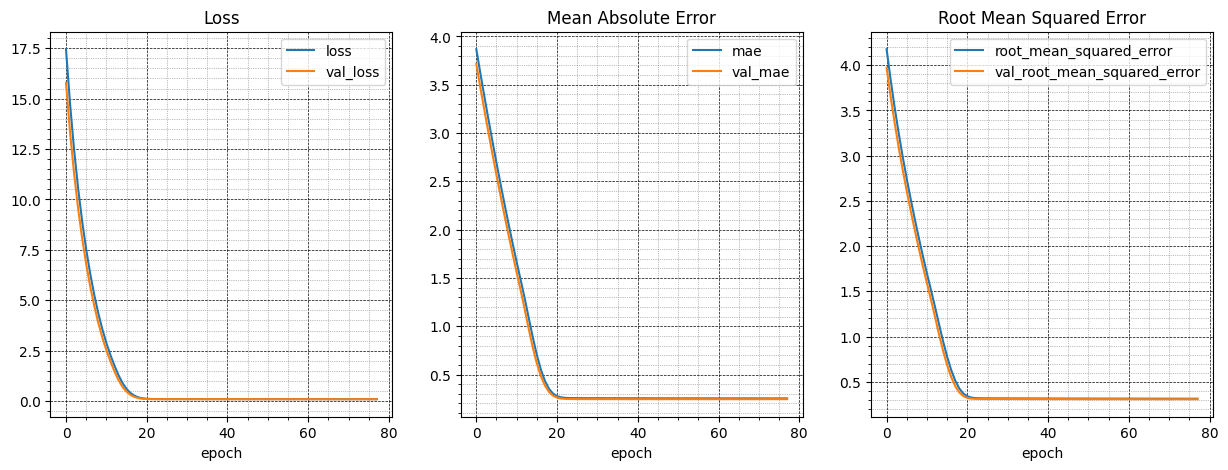

In [19]:
# extract the history dictionary from the keras callback:
history_data = history.history

# drop the r2 scores from the history, getting a dictionary of just loss:
history_data.pop('r2_score', None)
history_data.pop('val_r2_score', None)

# list of metrics, text conversion, & halfway point:
metric_list = list(history_data.keys())
half = int(len(history_data.keys())/2)
metric2text = {'loss' : 'Loss',
               'mae' : 'Mean Absolute Error',
               'root_mean_squared_error': 'Root Mean Squared Error'
               }

# training history analysis:
plt.figure(figsize = (half * 5,5))

# iterate and plot the training values:
for index, metric in enumerate(metric_list[:half]):
    training_metric = metric
    validation_metric = metric_list[index + half]

    plt.subplot(1, half, index + 1)
    plt.plot(history_data[training_metric], label = training_metric)
    plt.plot(history_data[validation_metric], label = validation_metric)
    plt.xlabel('epoch')
    plt.legend(loc = 'upper right')
    plt.minorticks_on()
    plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
    plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
    plt.title(f'{metric2text[training_metric]}')

test this shit:

In [20]:
# need to get the test metrics through model evaluation:
test_loss, test_mae, test_rmse = model.evaluate(x_test, y_test)

# need to get the predictions of the model:
pred_start = time.time()
y_pred = model.predict(x_test)
pred_time = time.time() - pred_start

# get the R2 score:
test_r2 = r2_score(y_test, y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1051 - mae: 0.2608 - root_mean_squared_error: 0.3240
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


results:

In [21]:
# print model parameters to user:
print(f'test MSE was: {test_loss}\n',
      f'test MAE was: {test_mae}\n', 
      f'test RMSE was: {test_rmse}\n',
      f'test r2 score was: {test_r2}\n',
      f'prediction time was: {round(pred_time, 3)} seconds')

test MSE was: 0.09934953600168228
 test MAE was: 0.254804790019989
 test RMSE was: 0.315197616815567
 test r2 score was: 0.9594424962997437
 prediction time was: 0.772 seconds


visualize through scatter plot:

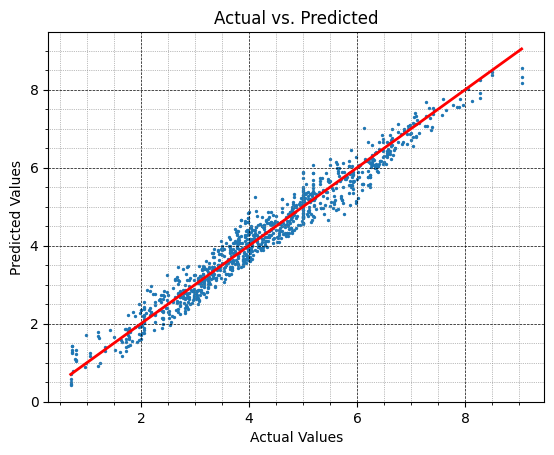

In [22]:
# scatter plot analysis:
plt.figure()
plt.scatter(y_test, y_pred, s = 2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', lw = 2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

histogram of errors:

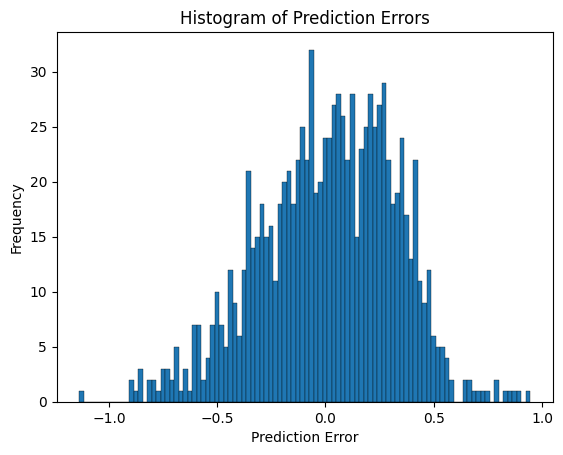

In [23]:
# histogram analysis:
y_test = np.array(y_test).reshape(-1, 1)
error = y_test - y_pred

plt.figure()
plt.hist(error, bins = 100, edgecolor = 'black', linewidth = 0.25)

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

plt.show()